## Generate a PSD plot framework for future plots:

In [1]:
#Purisa Jasmine Simmons
#August 2018

#Date:
#Trying to collect same info from this buoy: 
#Hs: 0.50-0.52m, Period: 

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE3), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [2]:
ride_ids = ['16083']
# 14743 - Motion Control July 10, 2018
# 14750 - Magnetometer Control July 11, 2018
# 14814 - Pool Displacement Control July 17, 2018
# 14815 - Compass Orientation (Lying on Charger Side) July 19, 2018
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20, 2018
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23, 2018)
# 14888 - First Buoy Calibration Experiment (July 30, 2018)
# 16083 - Scripps Nearshore Buoy #201 float experiment (May 15, 2019)

In [3]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    



In [4]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/16083
https://surf.smartfin.org/media/201905/google_105349665704999793400_0006667E229D_190515161151_Ocean.CSV
                              Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                           
2019-05-15 16:11:50.770  762167903            303                    18.938   
2019-05-15 16:11:56.828  762173923            303                    18.938   
2019-05-15 16:12:02.886  762179942            303                    18.938   
2019-05-15 16:12:08.945  762185962            303                    18.938   
2019-05-15 16:12:15.003  762191982            303                    18.938   
2019-05-15 16:12:21.062  762198002            303                    18.938   
2019-05-15 16:12:27.120  762204021            303                    18.938   
2019-05-15 16:12:33.178  762210041            303                    18.938   
2019-05-15 16:12:39.236  762216060            303                    

## Make a copy of the original motion_df dataframe

In [5]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                        Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
16083   2019-05-15 16:11:51.231  762168371.0   -59.0   505.0    63.0     3.0   
        2019-05-15 16:11:51.264          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.297          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.330          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.363          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.396          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.429          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.462  762168623.0   -56.0   493.0    62.0   -68.0   
        2019-05-15 16:11:51.495          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.528          NaN     NaN     NaN     NaN     NaN   
        2019-05-15 16:11:51.561         

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [6]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array1 = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array2 = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array3 = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array1.append(x)
        imu_array2.append(y)
        imu_array3.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array1[-1])
del(imu_array2[-1])
del(imu_array3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array1))
print(len(imu_array2))
print(len(imu_array3))





6202
6202
6202
6202
6202


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

6202
6202
6202
Graph of our entire experiment:


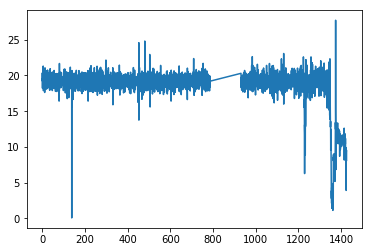

In [7]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity + gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

##To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imu2_array))

print("Graph of our entire experiment:")

plt.plot(time_e_array, imu2_array)
#plt.ylim(-1,1)
plt.show()

#print("Why are the y-axis values so small?")

## Step 1: Seperate each of the subexperiments into its own acc lists

In [8]:
#for x in time_e_array:
#    print(x)

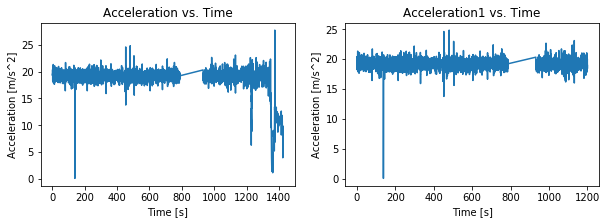

In [9]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []


#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 0 and time_e_array[i] <= 1200): #whole signal
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 200 and time_e_array[i] <= 800): #first half, low noise
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 980 and time_e_array[i] <= 1100): #2nd half, low noise
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')


ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])


plt.show()
    

## Step 2: Detrend and Double Integrate the data 

In [10]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

f_s = 5.0 #sampling frequency


### Bandpass filter the data

In [11]:
#First integral of acc to get velocity:
from scipy import integrate

def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t > low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array


/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



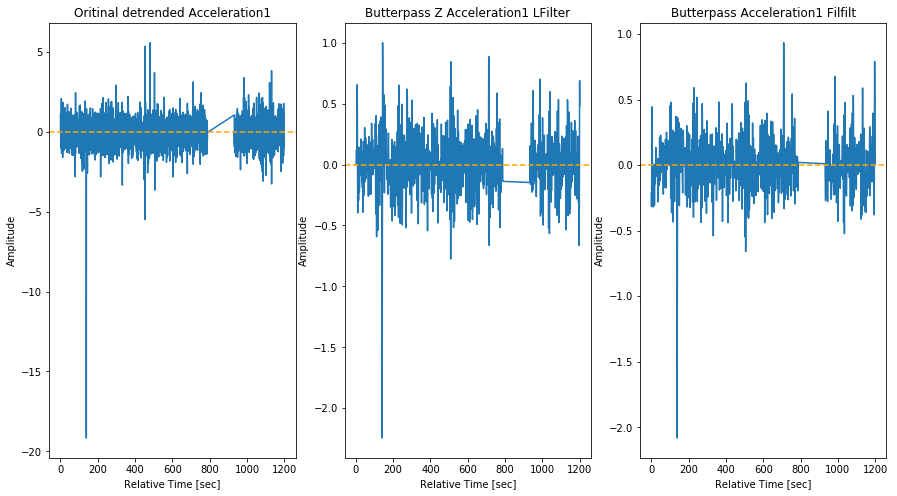

In [12]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
fs = 30
lowcut = 0.0333
highcut = 1.5

##Graphing the bandpass filters:
butter_lfilter = butter_bandpass_lfilter(dacc_array1, lowcut, highcut, fs, order=5)
butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)


new_time = time_array1.copy()

for i in range(len(new_time)):
    if i == 0:
        new_time[i] = 0
    else:
        new_time[i] = new_time[i-1] + 1/fs

        


fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)

ax1.plot(time_array1, dacc_array1)
ax1.set_title('Oritinal detrended Acceleration1')
ax1.set_xlabel('Relative Time [sec]')
ax1.set_ylabel('Amplitude')
ax1.axhline(0, color="orange",ls='--')


ax2.plot(time_array1, butter_lfilter)
ax2.set_title('Butterpass Z Acceleration1 LFilter')
ax2.set_xlabel('Relative Time [sec]')
ax2.set_ylabel('Amplitude')
ax2.axhline(0, color="orange",ls='--')

ax3.plot(time_array1, butter_filtfilt)
ax3.set_title('Butterpass Acceleration1 Filfilt')
ax3.set_xlabel('Relative Time [sec]')
ax3.set_ylabel('Amplitude')
ax3.axhline(0, color="orange",ls='--')


plt.show()

## Removes outliers larger than 3x the standard deviation:

In [13]:
#Removes outliers from the array (outliers = values larger than 3x the standard deviation) and replaces them with the mean value.

def func_remove_outliers(acc_array):
    updated_acc_array = []
    std = np.std(acc_array)
    #print("Std: ", std)
    mean = np.median(acc_array)
    #print("Mean: ", mean)
    for value in acc_array:
        if value > mean + 3*std:
            #print("Value is:", value)
            value = mean
        elif value < -mean - 3*std:
            value = -mean
        updated_acc_array.append(value)
    
    return updated_acc_array

Starting subexperiment 1 analysis:


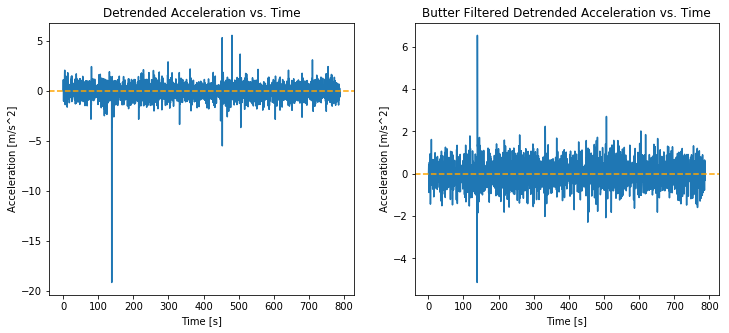

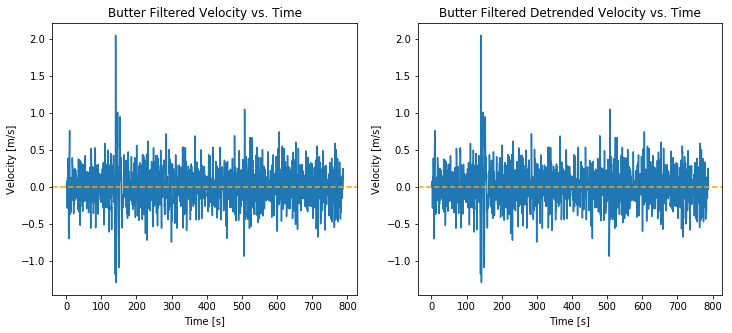

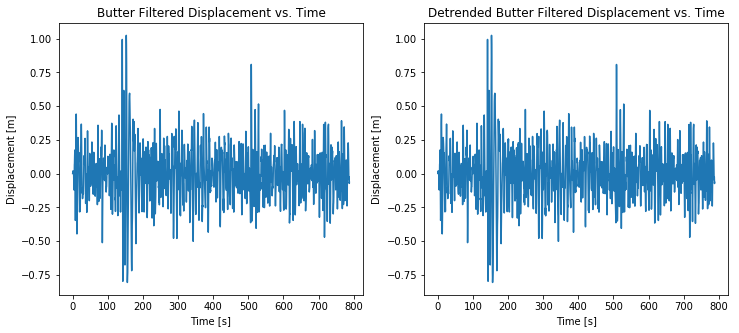

Done.
Starting subexperiment 2 analysis:


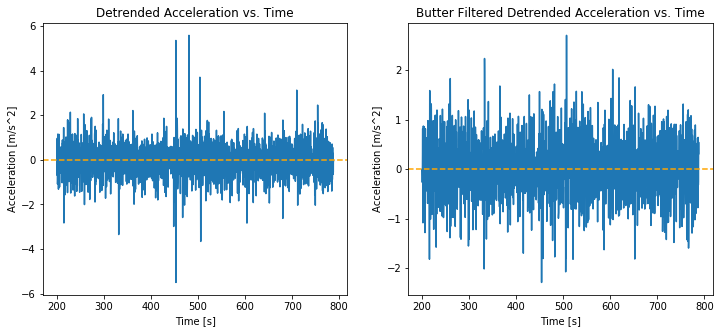

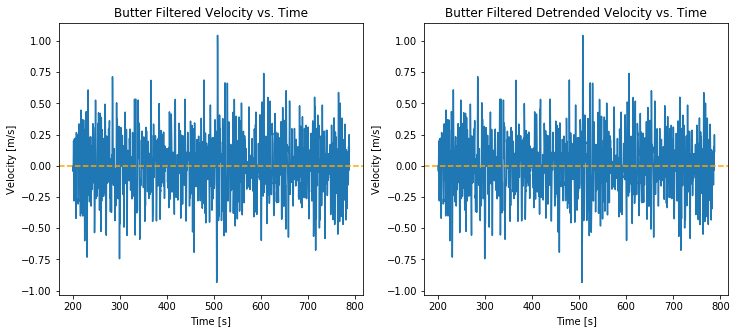

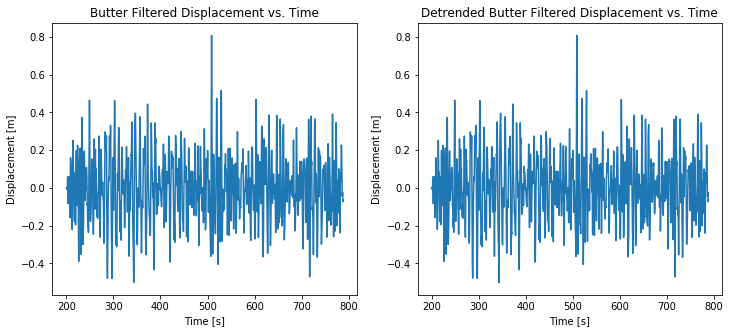

Done.
Starting subexperiment 3 analysis:


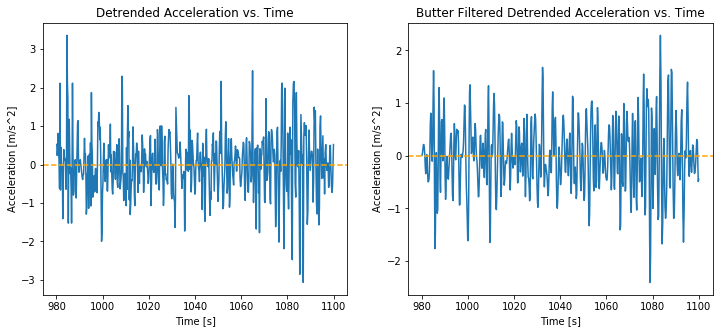

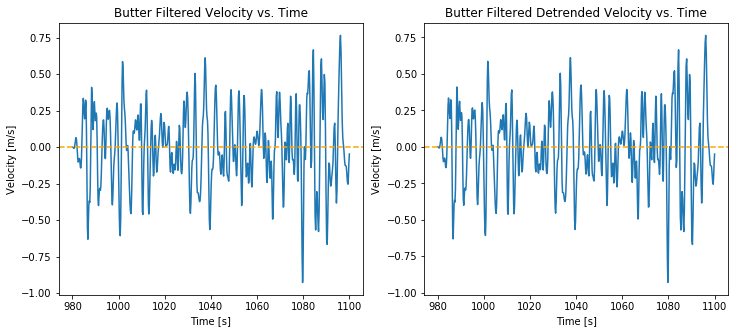

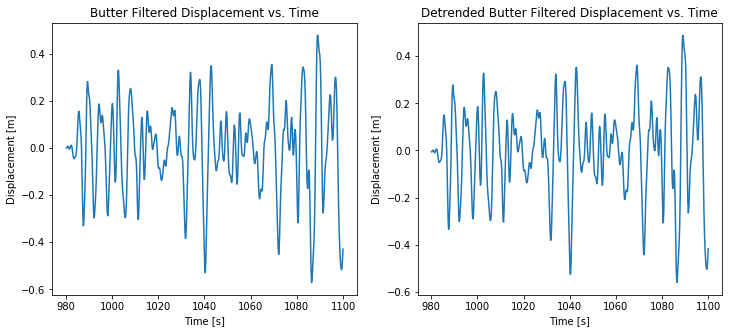

Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.


In [14]:
# Define the sample rate and the Low and High Cutoff frequencies

fs = 5 #redefine the sampling frequency

order=6
lowcut = 0.09
highcut = 1.0

def double_integral_bandpass(time_array, acc_array, dacc_array, lowcut, highcut, fs, order):
    
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)



    f1 = plt.figure(figsize=(12,5))
    ax1 = f1.add_subplot(121)
    ax2 = f1.add_subplot(122)

    f2 = plt.figure(figsize=(12,5))
    ax3 = f2.add_subplot(121)
    ax4 = f2.add_subplot(122)
    
    f3 = plt.figure(figsize=(12,5))
    ax5 = f3.add_subplot(121)
    ax6 = f3.add_subplot(122)

    #Acceleration graphs:
    ax1.plot(time_array, dacc_array)
    ax1.set_title('Detrended Acceleration vs. Time')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Acceleration [m/s^2]')
    ax1.axhline(0, color="orange", ls='--')
    
    ax2.plot(time_array, butter_lfilter)
    ax2.set_title('Butter Filtered Detrended Acceleration vs. Time')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Acceleration [m/s^2]')
    ax2.axhline(0, color="orange", ls='--')
    
    #Velocity graphs:
    ax3.plot(time_array, v_butter_filter_integral)
    ax3.set_title('Butter Filtered Velocity vs. Time')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Velocity [m/s]')
    ax3.axhline(0, color="orange", ls='--')


    ax4.plot(time_array, detrend_v_integral)
    ax4.set_title('Butter Filtered Detrended Velocity vs. Time')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Velocity [m/s]')
    ax4.axhline(0, color="orange",ls='--')

    
    #Displacement graphs:
    ax5.plot(time_array, disp_butter_filter_integral)
    ax5.set_title('Butter Filtered Displacement vs. Time')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Displacement [m]')               
    
    ax6.plot(time_array, detrend_disp_butter_integral)
    ax6.set_title('Detrended Butter Filtered Displacement vs. Time')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement [m]')


    plt.show()
    
    return detrend_disp_butter_integral

    
    
##For subexperiment1:
print("Starting subexperiment 1 analysis:")
#Get as close to just the signal (don't want noise)    
new_t1, new_acc1 = calculate_new_range(time_array1, acc_array1, 0, 800)    
new_t1, new_dacc1 = calculate_new_range(time_array1, dacc_array1, 0, 800)
new_acc1 = func_remove_outliers(new_acc1)
disp_butter_integral1 = double_integral_bandpass(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs, order)
print("Done.")

##For subexperiment2:
print("Starting subexperiment 2 analysis:")
#Get as close to just the signal (don't want noise)    
new_t2, new_acc2 = calculate_new_range(time_array2, acc_array2, 200, 800)    
new_t2, new_dacc2 = calculate_new_range(time_array2, dacc_array2, 200, 800)
new_acc2 = func_remove_outliers(new_acc2)
disp_butter_integral2 = double_integral_bandpass(new_t2, new_acc2, new_dacc2, lowcut, highcut, fs, order)
print("Done.")

## For subexperiment3:
print("Starting subexperiment 3 analysis:")
new_t3, new_acc3 = calculate_new_range(time_array3, acc_array3, 980, 1100)    
new_t3, new_dacc3 = calculate_new_range(time_array3, dacc_array3, 980, 1100)
new_acc3 = func_remove_outliers(new_acc3)
disp_butter_integral3 = double_integral_bandpass(new_t3, new_acc3, new_dacc3, lowcut, highcut, fs, order)


## Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.

print("Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.")

### Remove outliers from the dataset (larger than 2x the standard deviation): 

In [15]:
#new_dacc1 = func_remove_outliers(new_dacc1)
#new_dacc2 = func_remove_outliers(new_dacc2)
#new_dacc3 = func_remove_outliers(new_dacc3)

new_dacc1 = disp_butter_integral1
new_dacc2 = disp_butter_integral2
new_dacc3 = disp_butter_integral3

## Peak Picking Algorithm:

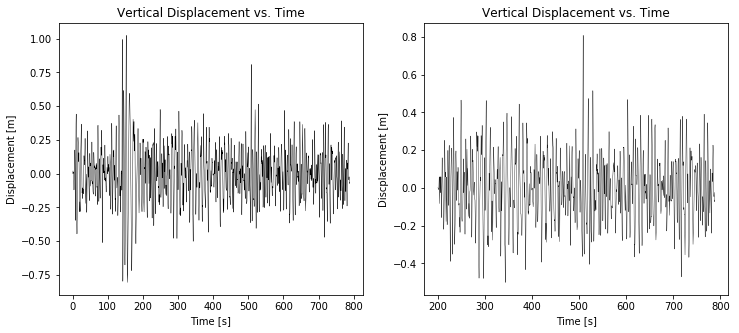

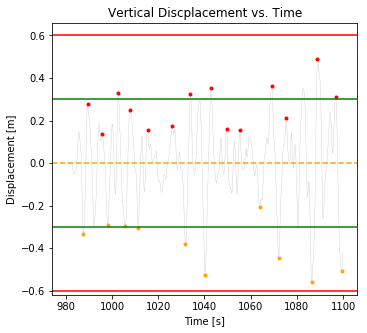

In [16]:
#First, find peaks and valleys of the waveforms:
#(Found that this works better when the data has been detrended.)

#Need to convert to numpy array types: 
new_dacc1 = np.array(new_dacc1)
new_dacc2 = np.array(new_dacc2)
new_dacc3 = np.array(new_dacc3)

new_t1 = np.array(new_t1)
new_t2 = np.array(new_t2)
new_t3 = np.array(new_t3)


indexes0 = peakutils.indexes(new_dacc1, thres=0.02/max(new_dacc1), min_dist=100)
indexes1 = peakutils.indexes(new_dacc2, thres=0.02/max(new_dacc2), min_dist=100)
indexes2 = peakutils.indexes(new_dacc3, thres=0.02/max(new_dacc3), min_dist=100)

col_0t = new_t1 # First column data
col_0a = new_dacc1 # Second column data

col_1t = new_t2 # First column data
col_1a = new_dacc2 # Second column data

col_2t = new_t3 # First column data
col_2a = new_dacc3 # Second column data



#Index1 gets the peaks, while index2 gets the valleys
index_max0 = peakutils.indexes(col_0a, thres=0.66, min_dist=25)
index_min0 = peakutils.indexes(-col_0a, thres=0.66, min_dist=25)

index_max1 = peakutils.indexes(col_1a, thres=0.66, min_dist=25)
index_min1 = peakutils.indexes(-col_1a, thres=0.66, min_dist=25)

index_max2 = peakutils.indexes(col_2a, thres=0.66, min_dist=25)
index_min2 = peakutils.indexes(-col_2a, thres=0.66, min_dist=25)



##Plotting:
f1 = plt.figure(figsize=(12,5))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(12,5))
ax3 = f2.add_subplot(121)


ax1.plot(col_0t,col_0a, lw=0.4, alpha=1.0, color='black' )
#ax1.plot(col_0t[index_max0],col_0a[index_max0], marker="o", ls="", ms=3, color="red" )
#ax1.plot(col_0t[index_min0],col_0a[index_min0], color ="orange", marker="o", ls="", ms=3 )
ax1.set_title("Vertical Displacement vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Displacement [m]')
#ax1.axhline(0, color="orange", ls='--')
#ax1.axhline(0.3, color="green", ls='-')
#ax1.axhline(-0.3, color="green", ls='-')
#ax1.axhline(0.6, color="red", ls='-')
#ax1.axhline(-0.6, color="red", ls='-')


ax2.plot(col_1t,col_1a, lw=0.4, alpha=0.9, color="black" )
#ax2.plot(col_1t[index_max1],col_1a[index_max1], marker="o", ls="", ms=3,  color="red" )
#ax2.plot(col_1t[index_min1],col_1a[index_min1], color ="orange", marker="o", ls="", ms=3 )
ax2.set_title("Vertical Displacement vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Discplacement [m]")


ax3.plot(col_2t,col_2a, lw=0.4, alpha=0.2, color="black" )
ax3.plot(col_2t[index_max2],col_2a[index_max2], marker="o", ls="", ms=3,  color="red" )
ax3.plot(col_2t[index_min2],col_2a[index_min2], color ="orange", marker="o", ls="", ms=3 )
ax3.set_title("Vertical Discplacement vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Displacement [m]")
ax3.axhline(0, color="orange", ls='--')
ax3.axhline(0.3, color="green", ls='-')
ax3.axhline(-0.3, color="green", ls='-')
ax3.axhline(0.6, color="red", ls='-')
ax3.axhline(-0.6, color="red", ls='-')


plt.show()


In [17]:
#for x in new_dacc1:
#    print(x)

### Choose the tallest 1/3 of waves to observe, then take the mean of that subset: 

In [18]:
#Calculating significant wave height by doing analysis over entire wave (not just max peaks picked):
print(len(new_dacc2))

n = int(len(new_dacc2)/3)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

#print(largest_third)

print(np.mean(largest_third))
wave_height = 2*np.mean(largest_third)
print("Significant wave height calculated as: ", wave_height)

2940
980
0.24276359473464473
Significant wave height calculated as:  0.48552718946928947


In [19]:
#Choosing significant height based on max peak-picking: 

print(len(index_max0))
n = int(len(index_max0)/3)
print(n)

max_dacc = []
for i in range(0,len(index_max0)):
    max_dacc.append(new_dacc1[index_max0])

max_dacc = np.array(max_dacc)
largest_third = (max_dacc[np.argsort(max_dacc)[-n:]])


print("Max Peak Picking significant wave height calculated as: ", 2*np.mean(largest_third))

13
4
Max Peak Picking significant wave height calculated as:  1.1601361569256694


In [20]:
#Instead, just calculate the mean wave height of all positive waves: 
print(len(new_dacc1))

n = int(len(new_dacc1)/2)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
all_sorted = (x0[np.argsort(x0)[-n:]])

print(all_sorted)

print(np.mean(all_sorted))
wave_height = 2*np.mean(all_sorted)
print("Significant wave height calculated as: ", wave_height)

3880
1940
[0.00177626 0.00182464 0.00203867 ... 1.00111967 1.01489173 1.02436898]
0.15075267562693595
Significant wave height calculated as:  0.3015053512538719


In [21]:
#Calculate mean of top 1/2 (only positive values): 
print(len(new_dacc1))

n = int(len(new_dacc1)/2)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

print(largest_third)

print(np.mean(largest_third))
wave_height = 2*np.mean(largest_third)
print("Significant wave height calculated as: ", wave_height)

3880
1940
[0.00177626 0.00182464 0.00203867 ... 1.00111967 1.01489173 1.02436898]
0.15075267562693595
Significant wave height calculated as:  0.3015053512538719


In [22]:
#Calculate mean of top 2/3 (maybe less obscured by outliers from top 1/3): 
print(len(new_dacc1))

n = int(len(new_dacc1)*2/3)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

print(largest_third)

print(np.mean(largest_third))
wave_height = 2*np.mean(largest_third)
print("Significant wave height calculated as: ", wave_height)

3880
2586
[-0.0796746  -0.07953384 -0.07949661 ...  1.00111967  1.01489173
  1.02436898]
0.1034520729511109
Significant wave height calculated as:  0.2069041459022218


In [23]:
#Calculate mean of top 1/3, after subtracting the top tenth: 
print(len(new_dacc1))

n = int(len(new_dacc1)/3)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

#Throw away top 10%: 
top_ten = int(len(largest_third/10))
largest_third_minus_top_tenth = (x0[np.argsort(x0)[top_ten:]])



print(largest_third_minus_top_tenth)

print(np.mean(largest_third_minus_top_tenth))
wave_height = 2*np.mean(largest_third_minus_top_tenth)
print("Significant wave height calculated as: ", wave_height)

3880
1293
[-0.07977667 -0.0796746  -0.07953384 ...  1.00111967  1.01489173
  1.02436898]
0.10338124622374929
Significant wave height calculated as:  0.20676249244749859


## Spectral Analysis: 

### Using Acceleration Data:

0.5379710144927536
Smartfin Peak Frequnecy:  0.5379710144927536
CDIP Peak Frequnecy:  0.06666666666
Frequency Standard Error:  7.069565218198261
Smartfin Peak Period:  1.8588362068965516
CDIP Peak Period:  15.0000000015
Period Standard Error:  0.8760775862192888


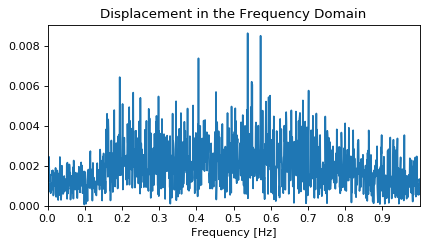

In [34]:
##Using Acceleration data:

from scipy import signal
f_s = 4.0

##PSD Step 2: Detrend the data 
#dacc_array = signal.detrend(new_dacc1)
dacc_array = dacc_array1

#Taking the FFT of acceleration:
fft_acc = np.fft.fft(dacc_array)
len_fft_acc = len(fft_acc)
freq_acc = np.fft.fftfreq(len_fft_acc, 1/f_s)

#Shifting the FFT of acceleration:
fft_acc_shifted = np.fft.fftshift(fft_acc)
freq_acc_shifted = np.fft.fftshift(freq_acc)

#Normalize:
fft_acc_normal = np.abs(fft_acc_shifted/len_fft_acc)*2


#Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:

f = abs(freq_acc_shifted[np.argmax(fft_acc_normal)])
print(f)

w = 2*np.pi*f
omega = 1/w**2

disp_normal = []

for a in fft_acc_normal:
    new_a = a*omega
    disp_normal.append(new_a)

#So now disp_normal should have the new values, 
#representing displacement in the frequency domain.


#Calculating wave statistics
peak_freq = np.abs(freq_acc_shifted[np.argmax(disp_normal)])
print("Smartfin Peak Frequnecy: ", peak_freq)

CDIP_peak_freq = 0.06666666666
print("CDIP Peak Frequnecy: ", CDIP_peak_freq)

print("Frequency Standard Error: ", abs(CDIP_peak_freq-peak_freq)/CDIP_peak_freq)

peak_period = float(1/peak_freq)
CDIP_peak_period = float(1/CDIP_peak_freq)


print("Smartfin Peak Period: ", peak_period)
print("CDIP Peak Period: ", CDIP_peak_period)
print("Period Standard Error: ", abs(CDIP_peak_period-peak_period)/CDIP_peak_period)



#representing displacement in the frequency domain.
fig = plt.figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(111) 


ax.plot(freq_acc_shifted, disp_normal)
ax.set_title("Displacement in the Frequency Domain")
ax.set_xlabel('Frequency [Hz]')
plt.xlim(0,1)
plt.ylim(0,)
plt.xticks(np.arange(0,1, step=.1))

plt.show()

### Using Displacement Data:

0.0829639175257732
Smartfin Peak Frequnecy:  0.0829639175257732
CDIP Peak Frequnecy:  0.06666666666
Frequency Standard Error:  0.2444587630110439
Smartfin Peak Period:  12.053432743087916
CDIP Peak Period:  15.0000000015
Period Standard Error:  0.19643781720782852


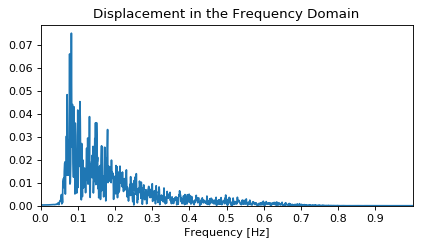

In [35]:
from scipy import signal
f_s = 3.7

##PSD Step 2: Detrend the data 
#dacc_array = signal.detrend(new_dacc1)
dacc_array = new_dacc1

#Taking the FFT of acceleration:
fft_acc = np.fft.fft(dacc_array)
len_fft_acc = len(fft_acc)
freq_acc = np.fft.fftfreq(len_fft_acc, 1/f_s)

#Shifting the FFT of acceleration:
fft_acc_shifted = np.fft.fftshift(fft_acc)
freq_acc_shifted = np.fft.fftshift(freq_acc)

#Normalize:
fft_acc_normal = np.abs(fft_acc_shifted/len_fft_acc)*2


#Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:

f = abs(freq_acc_shifted[np.argmax(fft_acc_normal)])
print(f)

w = 2*np.pi*f
omega = 1/w**2

disp_normal = []

for a in fft_acc_normal:
    new_a = a*omega
    disp_normal.append(new_a)

#So now disp_normal should have the new values, 
#representing displacement in the frequency domain.


#Calculating wave statistics
peak_freq = np.abs(freq_acc_shifted[np.argmax(fft_acc_normal)])
print("Smartfin Peak Frequnecy: ", peak_freq)

CDIP_peak_freq = 0.06666666666
print("CDIP Peak Frequnecy: ", CDIP_peak_freq)

print("Frequency Standard Error: ", abs(CDIP_peak_freq-peak_freq)/CDIP_peak_freq)

peak_period = float(1/peak_freq)
CDIP_peak_period = float(1/CDIP_peak_freq)


print("Smartfin Peak Period: ", peak_period)
print("CDIP Peak Period: ", CDIP_peak_period)
print("Period Standard Error: ", abs(CDIP_peak_period-peak_period)/CDIP_peak_period)



#representing displacement in the frequency domain.
fig = plt.figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(111) 


ax.plot(freq_acc_shifted, fft_acc_normal)
ax.set_title("Displacement in the Frequency Domain")
ax.set_xlabel('Frequency [Hz]')
plt.xlim(0,1)
plt.ylim(0,)
plt.xticks(np.arange(0,1, step=.1))

plt.show()
